In [1]:
#!pip install pysastrawi

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
nltk.download('punkt')
import re
import json
import pickle

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory= StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()
more_stopword = ['co', 'id', 'oleh','minggu','sabtu','senin','selasa','rabu','kamis','jumat']

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hardi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [38]:
data = pd.read_csv("DETEKSI_HOAKS.csv")
fake = data.loc[data['label']==0]
true = data.loc[data['label']==1]

In [39]:
display("fake",fake)
display("true",true)

'fake'

,label,text
0,0,Perhelatan Puncak Balapan Formula E Sepi Peno...
1,0,"Faktanya, Komisaris PT Persib Bandung Bermarta..."
2,0,Nonton Gratis Pertandingan Sepakbola Antara P...
3,0,Albert Einstein: “Kejahatan ada ketika manusi...
4,0,Surat Pengangkatan Tenaga Honorer Menjadi PNS...
...,...,...
503,0,Media sosial tengah dihebohkan sebuah video se...
504,0,Deolipa Yumara resmi melaporkan Ketua Umum Ali...
505,0,Dirut PT Taspen ANS Kosasih resmi melaporkan K...
506,0,Deolipa Yumara bersama tim kuasa hukumnya meny...


'true'

,label,text
249,1,Pemerintah melaporkan tambahan kasus COVID-19 ...
250,1,"Setelah enam episode berlalu, drama Korea Eve ..."
251,1,Empat hari berturut-turut kasus harian COVID-1...
252,1,Grace Natalie menegaskan PSI tak akan mendukun...
253,1,Pasal penghinaan ke penguasa masih muncul di d...
...,...,...
561,1,Pekan ini diwarnai sejumlah berita dari dunia ...
562,1,Dalam sepekan ini ada sejumlah berita menarik ...
563,1,Pemprov Jabar mencatat ada 4.265 berita atau i...
564,1,"""Orang nggak ada laporan, makanya kalau ada be..."


In [40]:
data['text'] = data['text'].apply(lambda x: x.lower())
for index, row in data.iterrows():
    text = row['text'].split(' ')
    if text[0] == 'jakarta':
        del text[0]
    data.iloc[index, data.columns.get_loc('text')] = ' '.join(text)
data

,label,text
0,0,perhelatan puncak balapan formula e sepi peno...
1,0,"faktanya, komisaris pt persib bandung bermarta..."
2,0,nonton gratis pertandingan sepakbola antara p...
3,0,albert einstein: “kejahatan ada ketika manusi...
4,0,surat pengangkatan tenaga honorer menjadi pns...
...,...,...
561,1,pekan ini diwarnai sejumlah berita dari dunia ...
562,1,dalam sepekan ini ada sejumlah berita menarik ...
563,1,pemprov jabar mencatat ada 4.265 berita atau i...
564,1,"""orang nggak ada laporan, makanya kalau ada be..."


In [41]:
#token for unormalize data
unnormalize = []
# fakeunnormalize =[]
# true
for index, row in data.iterrows():
    text = row['text']
    #text = stopword.remove(text)
    #text = text.encode("utf-8")
    #text_decode = str(text.decode("utf-8"))
    unnormalize += nltk.word_tokenize(text)
    
print("UNNORMALIZE TOKEN", len(unnormalize))
#remove duplicates
unnormalize_clean = list( dict.fromkeys(unnormalize))
print("UNNORMALIZE REMOVE DUPS", len(unnormalize_clean))

UNNORMALIZE TOKEN 14859
UNNORMALIZE REMOVE DUPS 4481


In [42]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# create stemmer
factory2 = StemmerFactory()
stemmer = factory2.create_stemmer()
def textEncode(text):
    text = text.encode("utf-8")
    text_decode = str(text.decode("utf-8"))
def casefolding(review):
    review = review.lower()
    return review
def tokenize(review):
    token =nltk.word_tokenize(review)
    return token
def stemming(review):
    review = stemmer.stem(review)
    return review
def filtering(review):
    review=re.sub(r'http\S+',' ',review)
    #
    review=re.sub('@[^\s]+',' ',review)
    #
    review=re.sub(r'#([^\s]+)','',review)
    #
    review=re.sub(r'[^\x00-\x7f]',r'',review)
    review=re.sub(r'(\\u[0-9A-Fa-f]+)',r'',review)
    review=re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ",review)
    review=re.sub(r'\\u\w\w\w\w','',review)
    #
    review=re.sub(r"[.,:;+!\-_<^/=?\"'\(\)\d\*]", " ",review)
    return review 
def replaceThreeOrMore(review):
    pattern= re.compile(r"(.)\1{1,}",re.DOTALL)
    return pattern.sub(r"\1\1", review)
def removeDoubleSpaces(review):
    while '  ' in review:
        review= review.replace('  ',' ')
    return review
# def convertToSlangword(review):
#     kamus_slangword = open("slangword.txt",encoding="utf8").read()
#     kamus_slangword = json.loads(kamus_slangword)
#     review = review.split(' ')
#     content=[]
#     for kata in review:
#         if kata in kamus_slangword:
#             kata = kamus_slangword[kata]
#         content.append(kata)
#     return ' '.join(content)
def removeStopword(review):
#     stopwords = open('stopwords.txt','r').read().split()
#     content= []
#     filteredtext = [word for word in review.split() if word not in stopwords]
#     content.append(" ".join(filteredtext))
#     review = content
    review = stopword.remove(review)
    return review
def process_text(s):
    
    #checking punctuation
    nopunc = [char for char in s if char not in string.punctuation]
    
    nopunc = ''.join(nopunc)
    
    #convert string to lowercase
    clean_string = [word for word in nopunc.split() if word.lower() not in stopwords.words('indonesian')]
    return clean_string
    

In [43]:
#test
#test
normalize = []
fake = []
true = []
for index, row in data.iterrows():
    test = row['text']
    test = casefolding(test)
     #print(test)
    test = filtering(test)
    test = stemming(test)
    #print(test)
    test = replaceThreeOrMore(test)
    #print(test)
    test = removeDoubleSpaces(test)
    #print(test)
#     test = convertToSlangword(test)
      #print(test)
    test = removeStopword(test)
      #print(test)
    test = tokenize(test)
    #print(test)
    normalize += test
    if row['label'] == 1 :
        true += test
    else:
        fake += test
print("NORMALIZE TOKEN", len(normalize))
normalize_clean = list(dict.fromkeys(normalize))
print("NORMALIZE REMOVE DUPS", len(normalize_clean))

NORMALIZE TOKEN 7443
NORMALIZE REMOVE DUPS 2714


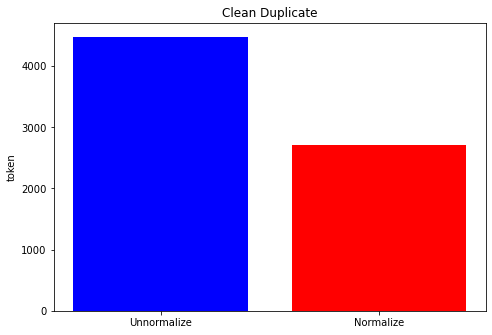

Dataset dinormalisasi sebesar 60.56683775942871%


In [44]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax= fig.add_axes([0,0,1,1])
langs = ['Unnormalize', 'Normalize']
students = [len(unnormalize_clean),len(normalize_clean)]
ax.bar(langs,students,color=['blue','red'])
ax.set_ylabel('token')
plt.title("Clean Duplicate")
plt.show()
normalpercent = (len(normalize_clean)/len(unnormalize_clean))*100
print("Dataset dinormalisasi sebesar "+ str(normalpercent)+"%")

In [45]:
!pip install wordcloud

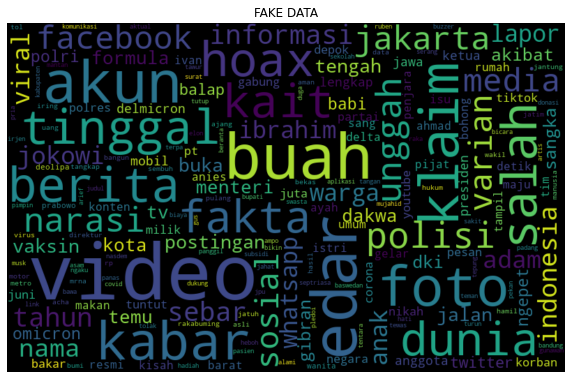

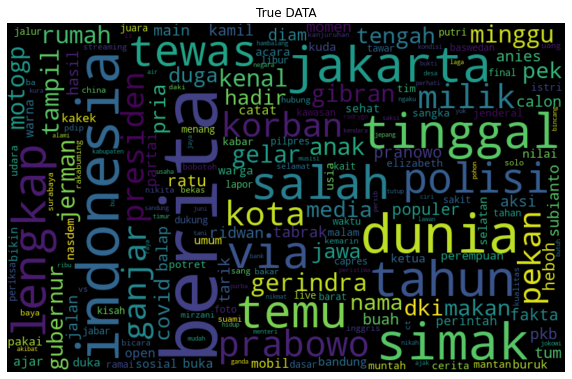

In [46]:
from wordcloud import WordCloud
all_words = ' '.join(normalize)
wordcloud = WordCloud(width=800, height=500,
                     max_font_size = 110,
                     collocations = False).generate(all_words)

all_words = ' '.join(fake)
wordcloud = WordCloud(width=800, height=500,
                     max_font_size = 110,
                     collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("FAKE DATA")
plt.show()

all_words = ' '.join(true)
wordcloud = WordCloud(width=800, height=500,
                     max_font_size = 110,
                     collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("True DATA")
plt.show()

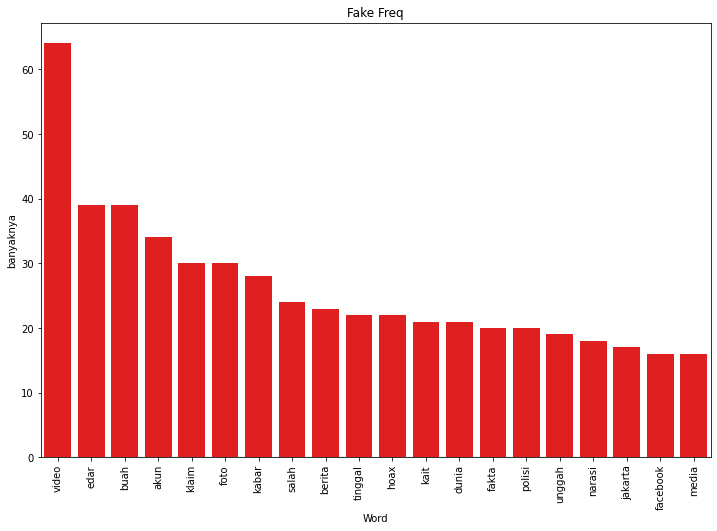

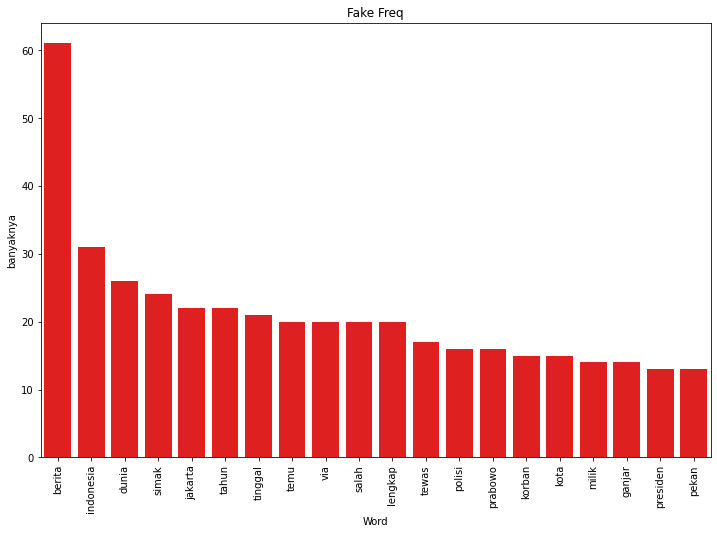

In [47]:
token_phrase = normalize
frequency = nltk.FreqDist(token_phrase)
df_frequency = pd.DataFrame({"Word":list(frequency.keys()),
                            "Frequency":list(frequency.values())})
token_phrase = fake
frequency = nltk.FreqDist(token_phrase)
df_frequency = pd.DataFrame({"Word":list(frequency.keys()),
                            "Frequency":list(frequency.values())})
df_frequency = df_frequency.nlargest(columns = "Frequency", n = 20)
plt.figure(figsize=(12,8))
ax= sns.barplot(data=df_frequency, x = "Word", y="Frequency", color= 'red')
ax.set(ylabel = "banyaknya")
plt.xticks(rotation = 'vertical')
plt.title('Fake Freq')
plt.show()

token_phrase = true
frequency = nltk.FreqDist(token_phrase)
df_frequency = pd.DataFrame({"Word":list(frequency.keys()),
                            "Frequency":list(frequency.values())})
df_frequency = df_frequency.nlargest(columns = "Frequency", n = 20)
plt.figure(figsize=(12,8))
ax= sns.barplot(data=df_frequency, x = "Word", y="Frequency", color ='red')
ax.set(ylabel = "banyaknya")
plt.xticks(rotation = 'vertical')
plt.title('Fake Freq')
plt.show()

In [48]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory,StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# create stemmer
factory2 = StemmerFactory()
stemmer = factory2.create_stemmer()
stop_factory = StopWordRemoverFactory().get_stop_words()
more_stopword = ['co', 'id', 'oleh','minggu','sabtu','senin','selasa','rabu','kamis','jumat']

new_stopword = stop_factory+ more_stopword
dictionary = ArrayDictionary(new_stopword)
stopword = StopWordRemover(dictionary)
stopword


In [49]:
def process_text(review):
    #case folding
    review = review.lower()
    # menghapus link
    review=re.sub(r'http\S+',' ',review)
    #menghapus username
    review=re.sub('@[^\s]+',' ',review)
    #menghapus tanda baca
    review=re.sub(r'#([^\s]+)','',review)
    review=re.sub(r'[^\x00-\x7f]',r'',review)
    review=re.sub(r'(\\u[0-9A-Fa-f]+)',r'',review)
    review=re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ",review)
    review=re.sub(r'\\u\w\w\w\w','',review)
    #
    review=re.sub(r"[.,:;+!\-_<^/=?\"'\(\)\d\*]", " ",review)
    pattern= re.compile(r"(.)\1{1,}",re.DOTALL)
    review = pattern.sub(r"\1\1", review)
    
    
    while '  ' in review:
        review= review.replace('  ',' ')
    #menghapus stopword
    review = stopword.remove(review)
    #Stem kata
    review = stemmer.stem(review)
    #tokenisasi
    token =nltk.word_tokenize(review)
    
    return token
def rebrand(review):
    if review['label'] == 0:
        review['label'] = 'fake'
    else:
        review['label'] = 'true'
    return review

In [50]:
data_rebrand = data.apply(rebrand,axis = 1)
dataprocessed = data_rebrand.sample(frac=1)
dataprocessed

,label,text
211,fake,gibran rakabuming raka mengungkap fakta lain d...
265,true,kementerian pertanian membuka pendaftaran beas...
447,true,"walau sudah memiliki dua anak, penampilan sand..."
457,true,nikita mirzani kemarin heboh dikabarkan jadi t...
109,fake,video viral 'tol becakayu ambruk' dipastikan ....
...,...,...
334,true,ingat betapa hebohnya serial squid game hingga...
296,true,tebak-tebakan sederhana ini bisa mengolahragak...
285,true,pernikahan adat bugis-makassar digelar meriah ...
483,true,chen kaishi yang dikenal dengan gu yazhen mema...


In [51]:
import string
def process_text2(s):
    
    #checking punctuation
    nopunc = [char for char in s if char not in string.punctuation]
    
    nopunc = ''.join(nopunc)
    
    #convert string to lowercase
    clean_string = [word for word in nopunc.split() if word.lower() not in new_stopword]
    return clean_string

In [52]:
dataprocessed['token'] = dataprocessed['text'].apply(process_text)

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
import string

In [54]:
dataprocessed.sample(40)
bow_transformer = CountVectorizer(analyzer=process_text2).fit(dataprocessed['token'])

print(len(bow_transformer.vocabulary_))

559


In [55]:
dataprocessed['token']
dataprocessed['token'].to_csv('outlasted.csv', index=False)

In [56]:
news_bow = bow_transformer.transform(dataprocessed['token'])

In [57]:
print('shape :',news_bow.shape)
print('amnt of non zero occ :',news_bow.nnz)

shape : (566, 559)
amnt of non zero occ : 566


In [58]:
spars = (100.0 *news_bow.nnz/(news_bow.shape[0]*news_bow.shape[1]))
print('spars: {}'.format(round(spars)))

spars: 0


In [59]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(news_bow)
news_tfidf = tfidf_transformer.transform(news_bow)
print(news_tfidf.shape)

(566, 559)


In [60]:
#train nbmodel
from sklearn.naive_bayes import MultinomialNB
fakenews_detect_model = MultinomialNB().fit(news_tfidf,dataprocessed['label'])

In [61]:
prediction = fakenews_detect_model.predict(news_tfidf)
print(prediction)

['fake' 'true' 'true' 'true' 'fake' 'true' 'fake' 'true' 'fake' 'fake'
 'true' 'true' 'fake' 'true' 'true' 'true' 'true' 'fake' 'true' 'true'
 'fake' 'fake' 'fake' 'true' 'fake' 'true' 'true' 'true' 'fake' 'true'
 'true' 'fake' 'fake' 'fake' 'true' 'true' 'fake' 'fake' 'true' 'true'
 'fake' 'true' 'true' 'true' 'true' 'true' 'fake' 'true' 'true' 'true'
 'true' 'true' 'true' 'fake' 'true' 'true' 'true' 'true' 'fake' 'fake'
 'true' 'true' 'true' 'fake' 'true' 'fake' 'true' 'fake' 'fake' 'true'
 'true' 'fake' 'fake' 'true' 'true' 'true' 'true' 'true' 'fake' 'true'
 'true' 'fake' 'fake' 'fake' 'true' 'fake' 'true' 'fake' 'fake' 'fake'
 'fake' 'true' 'fake' 'fake' 'true' 'true' 'true' 'true' 'fake' 'true'
 'fake' 'fake' 'fake' 'fake' 'true' 'fake' 'fake' 'fake' 'fake' 'true'
 'fake' 'fake' 'true' 'true' 'true' 'true' 'fake' 'fake' 'true' 'fake'
 'fake' 'true' 'true' 'fake' 'true' 'true' 'fake' 'fake' 'fake' 'true'
 'true' 'fake' 'true' 'fake' 'fake' 'fake' 'true' 'true' 'true' 'true'
 'fake

In [62]:
from sklearn.metrics import classification_report
print (classification_report(dataprocessed['label'],prediction))

              precision    recall  f1-score   support

        fake       1.00      1.00      1.00       271
        true       1.00      1.00      1.00       295

    accuracy                           1.00       566
   macro avg       1.00      1.00      1.00       566
weighted avg       1.00      1.00      1.00       566



In [63]:
from sklearn.model_selection import train_test_split 
news_train, news_test,text_train,text_test = train_test_split(dataprocessed['text'],
                                                              dataprocessed['label'],test_size = 0.27,
                                                              random_state=0)

print(len(news_train), len(news_test), len(news_train)+len(news_test))

413 153 566


In [64]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process_text)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB(alpha = 1.0)),
])
pipeline.fit(news_train,text_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process_text at 0x000002380DEBCA60>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [65]:
news_test

89      “perahu wisatawan di hantam ombak laut pangan...
478    kisah rumah tangga ronal surapradja dan seruni...
127    baru-baru ini geger varian corona 'delmicron',...
115    gerard pique jadi korban  usai dikabarkan seli...
223    pria yang hendak meracik kuah sotonya, tanpa d...
                             ...                        
433    polisi masih memeriksa dua orang terkait acara...
374    sekretaris jenderal nato jens stoltenberg meny...
339    ratusan pesepeda nampak mencolok di kota brigh...
252    grace natalie menegaskan psi tak akan mendukun...
424    nasdem mengumumkan tiga nama bakal capres 2024...
Name: text, Length: 153, dtype: object

In [73]:
test =news_test.iloc[0]
test ='Media sosial tengah dihebohkan sebuah video seorang wanita menyebutkan ada pintu rahasia di rumah Irjen Ferdy Sambo. Polri memastikan bahwa video tersebut hoax.  https://t.co/elTjrLcJGr'
prediksi = pipeline.predict([test]) 
print(prediksi)

['fake']


In [67]:
#Media sosial tengah dihebohkan sebuah video seorang wanita menyebutkan ada pintu rahasia di rumah Irjen Ferdy Sambo. Polri memastikan bahwa video tersebut hoax.  https://t.co/elTjrLcJGr


In [68]:
predictions = pipeline.predict(news_test)
#print(predictions)
print(classification_report(predictions,text_test))

              precision    recall  f1-score   support

        fake       0.58      0.91      0.71        54
        true       0.93      0.65      0.76        99

    accuracy                           0.74       153
   macro avg       0.76      0.78      0.74       153
weighted avg       0.81      0.74      0.74       153



In [69]:
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score

# acc_score = accuracy_score(text_test, prediksi)
conf_mat = confusion_matrix(
        text_test, predictions)
print (conf_mat)

[[49 35]
 [ 5 64]]


In [70]:
conf_mat2 = confusion_matrix(
        dataprocessed['label'], prediction)
print (conf_mat2)

[[271   0]
 [  0 295]]


In [71]:
prediksi.shape

(1,)